<a href="https://colab.research.google.com/github/okada-t-rafael/pytorch_study/blob/master/04_pytorch_custom_datasets_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercises

## Exercise 1
Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.

Answer:

The main idea of preventing underfitting is to increase our model's predictive power.

1. Add more layers/units to yoru model (increase model complexity). This will potentially give the model more of an opportunity to learn generalizable patterns in the training data. For example, instead of using 2 hidden layers, use 4 hidden layers instead.

2. Use Transfer learning. Transfer learning helps to prevent underfitting by leveraging already existing/working patterns from one model/dataset and using them with your own problem.

3. Train the model for longer. Perhaps your initial schedule didn't give your model enough opportunity to learn patterns in the data. Training your model for longer (more epochs) may give imporoved results.



## Notebook Setup

In [1]:
!pip install -q torchinfo

In [2]:
import logging
import matplotlib.pyplot as plt
import os
import requests
import torch
import torchvision
import zipfile
from pathlib import Path
from timeit import default_timer as timer
from torch import nn
from torch.utils.data import DataLoader
from torchinfo import summary
from torchvision import datasets, transforms
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

In [3]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
!nvidia-smi

Sat Mar  2 19:52:26 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8              13W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Exercise 2

Recreate the data loading functions we built in sections 1, 2, 3 and 4. You yould have train and test `DataLoader`'s ready to use.

In [5]:
def download_zip_dataset(
        dataset_url: str,
        folder_name: str,
        ) -> Tuple[Path, bool]:
    """Downloads an image dataset from the given and then unzip it into
    the given path.

    The files within the zip must follow the structure:
    .
    |-- root_folder
        |-- test
        |   |-- class_one
        |   `-- class_two
        `-- train
            |-- class_one
            `-- class_tow

    Params:
    - dataset_url (str): An URL of a zip file containing images for each class,
    divided in the train and test subfolders.
    - folder_name (str): The name of the folder to be created when unzipping
    the zip file.

    Return:
    - [Tuple, bool]: Returns the path where the image were downloaded and a
    boolean indicating whether everything was executed as expected.
    """

    # Setup path to a data folder
    data_path: Path = Path("data")
    image_path: Path = data_path / folder_name

    # Check whether the image folder already exist, if not download it...
    if image_path.is_dir():
        logging.info(
            f"Directory '{image_path}' already exists. Skipping download.")
        return image_path, True

    logging.info(f"Creating directory: '{image_path}'.")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download zipfile
    zipfile_name = dataset_url.split("/")[-1]
    try:
        logging.info(f"Downloading: {zipfile_name}")
        req = requests.get(dataset_url)
    except requests.exceptions.RequestException as e:
        logging.error(f"Error while downloading '{dataset_url}':\n{e}")
        return Path(""), False

    # Saving downloaded file
    try:
        with open(data_path / zipfile_name, "wb") as f:
            f.write(req.content)
    except IOError as e:
        logging.error(f"Error while writing '{zipfile_name}':\n{e}")
        return Path(""), False

    # Unzip images
    try:
        with zipfile.ZipFile(data_path / zipfile_name, "r") as zip_ref:
            logging.info(f"Unzipping: {zipfile_name}")
            zip_ref.extractall(image_path)
    except Exception as e:
        logging.error(f"Error while unzipping '{zipfile_name}':\n{e}")
        return Path(""), False

    return image_path, True


In [6]:
def create_datasets(
        image_path: Path,
        transform: transforms.Compose
        ) -> Tuple[datasets.ImageFolder, datasets.ImageFolder]:
    """Creates the train and test datasets.

    Params:
    - image_path (Path): Location where the train and test folder are listed.
    - transform (transforms.Compose): Transformations to be applied to the
    images.

    Return:
    - Tuple[datasets.ImageFolder, datasets.ImageFolder]: Returns the train and
    test datasets.
    """
    # Create datasets
    logging.info(f"Creating Datasets.")

    train_dataset = datasets.ImageFolder(
        root=image_path / "train",
        transform=transform)

    test_dataset = datasets.ImageFolder(
        root=image_path / "test",
        transform=transform)

    return train_dataset, test_dataset

In [7]:
def create_dataloaders(
        train_dataset: datasets.ImageFolder,
        test_dataset: datasets.ImageFolder,
        batch_size: int=32
        ) -> Tuple[DataLoader, DataLoader]:
    """Turns train and test datasets into DataLoader's given a batch size.

    Params:
    - train_dataset (datasets.ImageFolder): Dataset containing the training
    images.
    - test_dataset (datasets.ImageFolder): Dataset containgin the test images.
    - batch_size (int): Size of the batch to be created for the dataloaders.
    """
    logging.info("Turning train and test datasets into dataloaders.")

    train_dataloader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        num_workers=os.cpu_count(),
        shuffle=True)

    test_dataloader = DataLoader(
        dataset=test_dataset,
        batch_size=batch_size,
        num_workers=os.cpu_count(),
        shuffle=False)

    return train_dataloader, test_dataloader

In [8]:
# Setting logging level.
logging.getLogger().setLevel(logging.INFO)

# Some definitions.
BATCH_SIZE = 32
DATASET_URL = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"
WORK_FOLDER = "pizza_steak_sushi"

# Donwload and unzip images.
image_path, _ = download_zip_dataset(DATASET_URL, WORK_FOLDER)

# Write a transform for image
data_transform = transforms.Compose([
    # Resize our images to 64x64
    transforms.Resize(size=(64, 64), antialias=None),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()])

# Create train and test datasets
train_dataset, test_dataset = create_datasets(
    image_path=image_path,
    transform=data_transform)

# Get class names as list
class_name_list = train_dataset.classes

# Turn train and test datasets into dataloaders
train_dataloader, test_dataloader = create_dataloaders(
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    batch_size=BATCH_SIZE)

INFO:root:Creating directory: 'data/pizza_steak_sushi'.
INFO:root:Downloading: pizza_steak_sushi.zip
INFO:root:Unzipping: pizza_steak_sushi.zip
INFO:root:Creating Datasets.
INFO:root:Turning train and test datasets into dataloaders.


## Exercise 3
Recreate `model_0` we built in section 7.

In [9]:
class TinyVGG(nn.Module):
    """Model archtecture copying TinyVGG CNN Explainer"""
    def __init__(
            self,
            in_channels: int,
            hidden_units: int,
            out_features: int,
            img_shape: Tuple[int, int]
            ) -> None:
        super().__init__()

        # First block
        self.conv_block_1, adj_img_shape = TinyVGG._create_conv_block(
            in_channels=in_channels,
            out_channels=hidden_units,
            img_shape=img_shape)

        # Second block
        self.conv_block_2, adj_img_shape = TinyVGG._create_conv_block(
            in_channels=hidden_units,
            out_channels=hidden_units,
            img_shape=adj_img_shape)

        # Classifier
        self.classifier = TinyVGG._create_classifier_block(
            in_features=hidden_units * adj_img_shape[0] * adj_img_shape[1],
            out_features=out_features)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))


    def _create_conv_block(
            in_channels: int,
            out_channels: int,
            img_shape: Tuple[int, int]
            ) -> Tuple[nn.Sequential, Tuple[int, int]]:
        """Creates a block of the neural network. This block includes two
        Conv2d and one MaxPool2d. And it also calculates the adjusted size of
        the 'image' for the flatten layer.

        Params:
        - in_channels (int): The input size channel of the first conv layer.
        - out_channels (int): The output size channel of the second conv layer.
        - img_shape (Tuple[int, int]): The shape of the 'image' after passing
        through this block. It is influenced by the Conv2d layers and the
        MaxPool2d layer (see documentatin to adjust accordinly).

        Return:
        - Tuple[nn.Sequential, Tuple[int, int]]: Returns the instance of the
        block and the adjusted size of the 'image'.
        """
        # Create the conv block
        conv_block = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=3,
                stride=1,
                padding=0),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=out_channels,
                out_channels=out_channels,
                kernel_size=3,
                stride=1,
                padding=0),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2,
                stride=2))

        # Calculate the ajusted image shape
        img_x, img_y = img_shape
        img_x -= 2  # first Conv2d
        img_x -= 2  # second Conv2d
        img_x = int(img_x / 2)  # MaPool2d
        img_y -= 2  # first Conv2d
        img_y -= 2  # second Conv2d
        img_y = int(img_y / 2)  # MaPool2d

        return conv_block, (img_x, img_y)


    def _create_classifier_block(
            in_features: int,
            out_features: int,
            ) -> nn.Sequential:
        """
        Creates a classifier block to the neural network. It is composed by a
        flatten layer and a linear layer.

        Params:
        - in_features (int): The number of features to be inserted in the
        linear layer. Note that this number must be ajusted to due to the
        flatten layer.
        - out_feataures (int): Number of labels for the neural network to
        predict.

        Return:
        - nn.Sequential: Returns an instance of the block.
        """
        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features=in_features,
                out_features=out_features
            )
        )


In [10]:
# Instanciate a TinyVGG model
torch.manual_seed(1000)
torch.cuda.manual_seed(1000)

model_0 = TinyVGG(
    in_channels=3,
    hidden_units=10,
    out_features=3,
    img_shape=(64, 64)
    ).to(device)

In [11]:
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [12]:
# Using torchinfo to get an idea of the shapes going through our model
summary(model_0, input_size=[32, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 30, 30]          --
│    └─Conv2d: 2-1                       [32, 10, 62, 62]          280
│    └─ReLU: 2-2                         [32, 10, 62, 62]          --
│    └─Conv2d: 2-3                       [32, 10, 60, 60]          910
│    └─ReLU: 2-4                         [32, 10, 60, 60]          --
│    └─MaxPool2d: 2-5                    [32, 10, 30, 30]          --
├─Sequential: 1-2                        [32, 10, 13, 13]          --
│    └─Conv2d: 2-6                       [32, 10, 28, 28]          910
│    └─ReLU: 2-7                         [32, 10, 28, 28]          --
│    └─Conv2d: 2-8                       [32, 10, 26, 26]          910
│    └─ReLU: 2-9                         [32, 10, 26, 26]          --
│    └─MaxPool2d: 2-10                   [32, 10, 13, 13]          --
├─Sequentia

In [13]:
# Creating a random tensor
torch.manual_seed(1000)
rand_tensor = torch.rand(1, 3, 64, 64)
rand_tensor.shape

torch.Size([1, 3, 64, 64])

In [14]:
# Try a forward pass to verify input shape for the flatten layer
model_0.eval()
with torch.inference_mode():
    logit_pred = model_0(rand_tensor.to(device))

## Exercise 4
Creata training and testing functions for `model_0`.

In [15]:
# Create a training step
def train_step(
        model: torch.nn.Module,
        dataloader: torch.utils.data.DataLoader,
        loss_fn: torch.nn.Module,
        optimizer: torch.optim.Optimizer,
        device: str
        ) -> Tuple[float, float]:

    # Put the model into target device
    model.to(device)

    # Pu the model in train mode
    model.train()

    # Setup train loss and train accuracy variables
    train_loss: float = 0.0
    train_acc: float = 0.0

    # Loop through dataloader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to the target device
        X = X.to(device)
        y = y.to(device)

        # 1. Forward pass
        y_pred_logits = model(X)  # output model logits

        # 2. Calculate the loss
        loss = loss_fn(y_pred_logits, y)
        train_loss += loss.item()  # convert this tensor to a standard python number

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate accuracy metric
        y_pred_probs = torch.softmax(y_pred_logits, dim=1)
        y_pred_labels = torch.argmax(y_pred_probs, dim=1)
        train_acc += (y_pred_labels == y).sum().item() / len(y_pred_labels)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc

In [16]:
# Create a test step
def test_step(
        model: torch.nn.Module,
        dataloader: torch.utils.data.DataLoader,
        loss_fn: torch.nn.Module,
        device: str) -> Tuple[float, float]:

    # Put model into target device
    model.to(device)

    # Put model in eval mode
    model.eval()

    # Step test loss and test accuracy variables
    test_loss: float = 0.0
    test_acc: float = 0.0

    # Turn on inference mode
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X = X.to(device)
            y = y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate the loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate the accuracy
            test_pred_probs = test_pred_logits.softmax(dim=1)
            test_pred_labels = test_pred_probs.argmax(dim=1)
            test_acc += (test_pred_labels == y).sum().item() / len(test_pred_labels)

        # Adjust metrics to get average loss and accuracy per batch
        test_loss = test_loss / len(dataloader)
        test_acc = test_acc / len(dataloader)

        return test_loss, test_acc

## Exercise 5
Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?

* Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer.

In [17]:
def plot_loss_curves(results: Dict[str, List[float]]) -> None:
    """Plots training curves of a results dictionary."""
    # Get the loss values of the results dictionary (training and test)
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    # Figure ou how many epochs there were
    epochs = range(len(results["train_loss"]))

    # Setup a plot
    plt.figure(figsize=(10, 4))

    # Plot the loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot the accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend();

In [18]:
def train(
        model: torch.nn.Module,
        train_dataloader: torch.utils.data.DataLoader,
        test_dataloader: torch.utils.data.DataLoader,
        optimizer: torch.optim.Optimizer,
        device: str,
        loss_fn: torch.nn.Module=nn.CrossEntropyLoss(),
        epochs: int=5) -> Dict[str, List[float]]:

    # Create an empty results dictionary
    results: Dict[str, List[float]] = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []}

    # Loop through training and testing steps for a number o epochs
    for epoch in tqdm(range(epochs)):
        # Training step
        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device)

        # Test step
        test_loss, test_acc = test_step(
            model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            device=device)

        # Print out what's happening
        print(
            f"Epoch: {epoch} | "
            f"Train_loss: {train_loss:.4f}, Train_acc: {train_acc:.3f}% | "
            f"Test_loss: {test_loss:.4f}, Test_acc: {test_acc:.3f}%")

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

Training Model_0 for 5 epochs.

In [19]:
# Set random seeds
torch.manual_seed(1000)
torch.cuda.manual_seed(1000)

# Set num of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0_5e = TinyVGG(
    in_channels=3,
    hidden_units=10,
    out_features=3,
    img_shape=(64, 64)).to(device)

# Setup loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0_5e.parameters(), lr=0.001)

# Start the timer
start_time = timer()

# Train model
model_0_5e_results = train(
    model=model_0_5e,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=NUM_EPOCHS,
    device=device)

# End timer and print out how long it took
end_time = timer()
print(f"Total training time: {(end_time - start_time):.3f} seconds.")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train_loss: 1.1095, Train_acc: 0.402% | Test_loss: 1.0845, Test_acc: 0.542%
Epoch: 1 | Train_loss: 1.1010, Train_acc: 0.281% | Test_loss: 1.0782, Test_acc: 0.542%
Epoch: 2 | Train_loss: 1.0884, Train_acc: 0.375% | Test_loss: 1.0895, Test_acc: 0.351%
Epoch: 3 | Train_loss: 1.0813, Train_acc: 0.449% | Test_loss: 1.0978, Test_acc: 0.333%
Epoch: 4 | Train_loss: 1.0550, Train_acc: 0.441% | Test_loss: 1.1130, Test_acc: 0.312%
Total training time: 5.274 seconds.


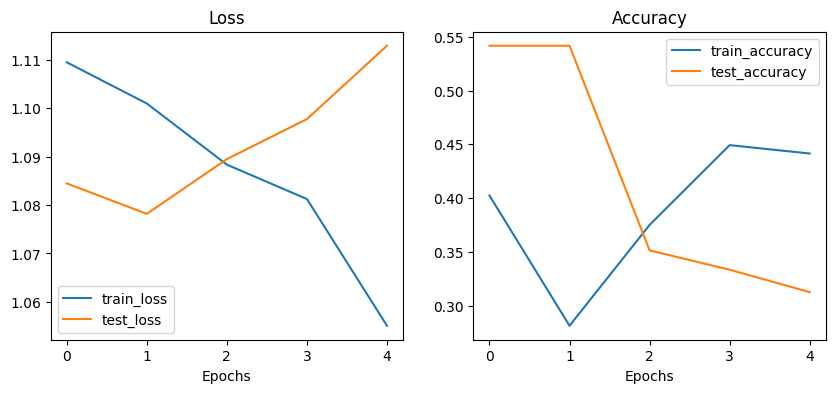

In [20]:
plot_loss_curves(model_0_5e_results)

Training Model_0 with 20 epochs.

In [21]:
# Set random seeds
torch.manual_seed(1000)
torch.cuda.manual_seed(1000)

# Set num of epochs
NUM_EPOCHS = 20

# Recreate an instance of TinyVGG
model_0_20e = TinyVGG(
    in_channels=3,
    hidden_units=10,
    out_features=3,
    img_shape=(64, 64)).to(device)

# Setup loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0_20e.parameters(), lr=0.001)

# Start the timer
start_time = timer()

# Train model
model_0_20e_results = train(
    model=model_0_20e,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=NUM_EPOCHS,
    device=device)

# End timer and print out how long it took
end_time = timer()
print(f"Total training time: {(end_time - start_time):.3f} seconds.")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | Train_loss: 1.1095, Train_acc: 0.402% | Test_loss: 1.0845, Test_acc: 0.542%
Epoch: 1 | Train_loss: 1.1010, Train_acc: 0.281% | Test_loss: 1.0782, Test_acc: 0.542%
Epoch: 2 | Train_loss: 1.0884, Train_acc: 0.375% | Test_loss: 1.0895, Test_acc: 0.351%
Epoch: 3 | Train_loss: 1.0813, Train_acc: 0.449% | Test_loss: 1.0978, Test_acc: 0.333%
Epoch: 4 | Train_loss: 1.0550, Train_acc: 0.441% | Test_loss: 1.1129, Test_acc: 0.312%
Epoch: 5 | Train_loss: 0.9891, Train_acc: 0.578% | Test_loss: 1.1126, Test_acc: 0.302%
Epoch: 6 | Train_loss: 0.9400, Train_acc: 0.613% | Test_loss: 1.0874, Test_acc: 0.281%
Epoch: 7 | Train_loss: 0.8663, Train_acc: 0.586% | Test_loss: 1.0209, Test_acc: 0.342%
Epoch: 8 | Train_loss: 0.7969, Train_acc: 0.613% | Test_loss: 1.2049, Test_acc: 0.374%
Epoch: 9 | Train_loss: 0.9423, Train_acc: 0.512% | Test_loss: 1.0824, Test_acc: 0.342%
Epoch: 10 | Train_loss: 0.8515, Train_acc: 0.594% | Test_loss: 1.0330, Test_acc: 0.403%
Epoch: 11 | Train_loss: 0.8195, Train_acc:

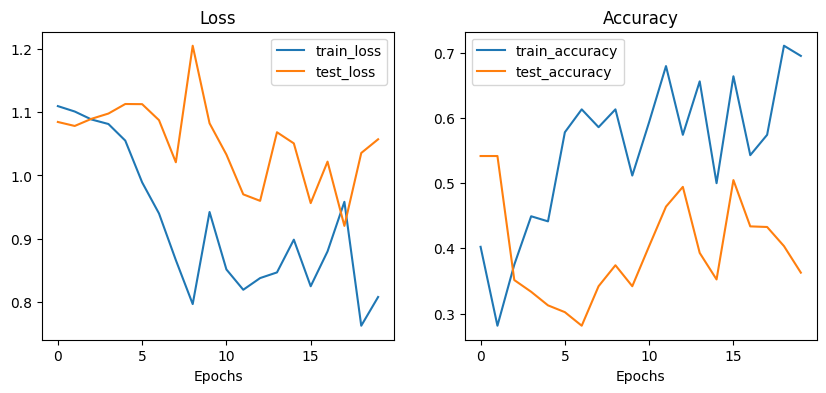

In [22]:
plot_loss_curves(model_0_20e_results)

Training Model_0 with 50 epochs.

In [23]:
# Set random seeds
torch.manual_seed(1000)
torch.cuda.manual_seed(1000)

# Set num of epochs
NUM_EPOCHS = 50

# Recreate an instance of TinyVGG
model_0_50e = TinyVGG(
    in_channels=3,
    hidden_units=10,
    out_features=3,
    img_shape=(64, 64)).to(device)

# Setup loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0_50e.parameters(), lr=0.001)

# Start the timer
start_time = timer()

# Train model
model_0_50e_results = train(
    model=model_0_50e,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=NUM_EPOCHS,
    device=device)

# End timer and print out how long it took
end_time = timer()
print(f"Total training time: {(end_time - start_time):.3f} seconds.")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 | Train_loss: 1.1095, Train_acc: 0.402% | Test_loss: 1.0845, Test_acc: 0.542%
Epoch: 1 | Train_loss: 1.1010, Train_acc: 0.281% | Test_loss: 1.0782, Test_acc: 0.542%
Epoch: 2 | Train_loss: 1.0884, Train_acc: 0.375% | Test_loss: 1.0895, Test_acc: 0.351%
Epoch: 3 | Train_loss: 1.0812, Train_acc: 0.449% | Test_loss: 1.0978, Test_acc: 0.333%
Epoch: 4 | Train_loss: 1.0551, Train_acc: 0.441% | Test_loss: 1.1130, Test_acc: 0.312%
Epoch: 5 | Train_loss: 0.9889, Train_acc: 0.578% | Test_loss: 1.1124, Test_acc: 0.292%
Epoch: 6 | Train_loss: 0.9382, Train_acc: 0.613% | Test_loss: 1.0839, Test_acc: 0.281%
Epoch: 7 | Train_loss: 0.8652, Train_acc: 0.590% | Test_loss: 1.0155, Test_acc: 0.342%
Epoch: 8 | Train_loss: 0.7941, Train_acc: 0.621% | Test_loss: 1.2064, Test_acc: 0.374%
Epoch: 9 | Train_loss: 0.9462, Train_acc: 0.516% | Test_loss: 1.0887, Test_acc: 0.342%
Epoch: 10 | Train_loss: 0.8507, Train_acc: 0.590% | Test_loss: 1.0372, Test_acc: 0.403%
Epoch: 11 | Train_loss: 0.8163, Train_acc:

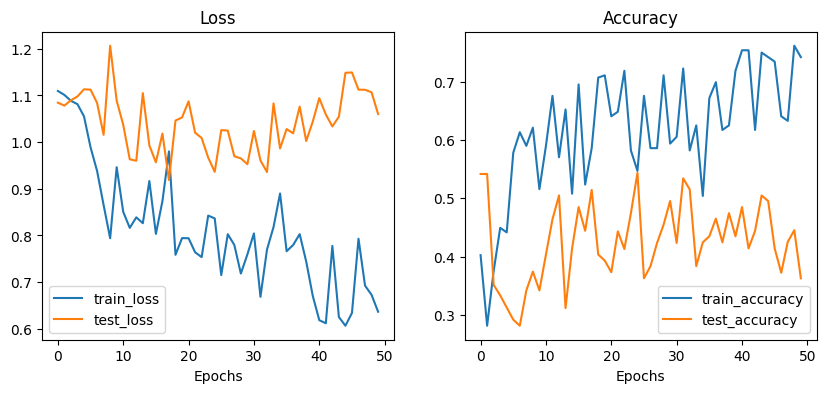

In [24]:
plot_loss_curves(model_0_50e_results)

## Exercise 6
Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [25]:
# Set random seeds
torch.manual_seed(1000)
torch.cuda.manual_seed(1000)

# Set num of epochs
NUM_EPOCHS = 20

# Recreate an instance of TinyVGG
model_1_20e = TinyVGG(
    in_channels=3,
    hidden_units=20,
    out_features=3,
    img_shape=(64, 64)).to(device)

# Setup loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1_20e.parameters(), lr=0.001)

# Start the timer
start_time = timer()

# Train model
model_1_20e_results = train(
    model=model_1_20e,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=NUM_EPOCHS,
    device=device)

# End timer and print out how long it took
end_time = timer()
print(f"Total training time: {(end_time - start_time):.3f} seconds.")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | Train_loss: 1.1087, Train_acc: 0.285% | Test_loss: 1.1012, Test_acc: 0.198%
Epoch: 1 | Train_loss: 1.1084, Train_acc: 0.293% | Test_loss: 1.0921, Test_acc: 0.208%
Epoch: 2 | Train_loss: 1.0766, Train_acc: 0.449% | Test_loss: 1.0862, Test_acc: 0.240%
Epoch: 3 | Train_loss: 1.0236, Train_acc: 0.516% | Test_loss: 1.0147, Test_acc: 0.434%
Epoch: 4 | Train_loss: 0.8955, Train_acc: 0.652% | Test_loss: 1.0696, Test_acc: 0.394%
Epoch: 5 | Train_loss: 0.8134, Train_acc: 0.660% | Test_loss: 0.9910, Test_acc: 0.352%
Epoch: 6 | Train_loss: 0.8441, Train_acc: 0.508% | Test_loss: 0.9703, Test_acc: 0.515%
Epoch: 7 | Train_loss: 0.8457, Train_acc: 0.641% | Test_loss: 0.9555, Test_acc: 0.514%
Epoch: 8 | Train_loss: 0.8211, Train_acc: 0.652% | Test_loss: 1.0969, Test_acc: 0.403%
Epoch: 9 | Train_loss: 0.8972, Train_acc: 0.695% | Test_loss: 1.1789, Test_acc: 0.374%
Epoch: 10 | Train_loss: 1.0158, Train_acc: 0.438% | Test_loss: 0.9604, Test_acc: 0.403%
Epoch: 11 | Train_loss: 0.8322, Train_acc:

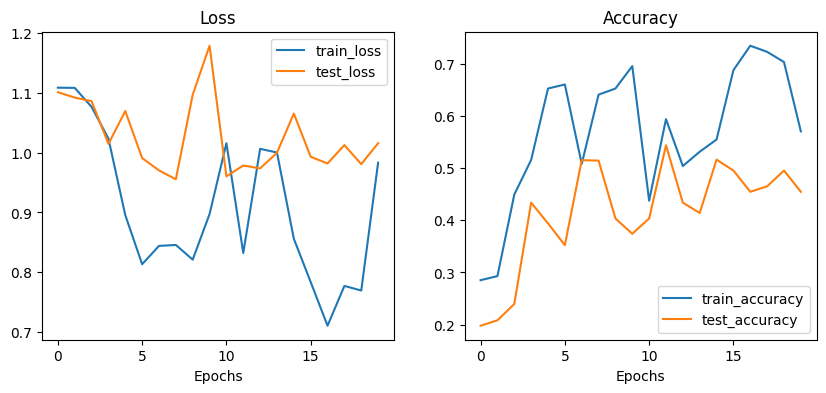

In [26]:
plot_loss_curves(model_1_20e_results)

## Exercise 7
Double the data you're using with you model and train it for 20 epochs, what happens to the results?

* **Note:** You can use the custom data creation notebook to scale up your Food101 dataset.

* You can also find the already formatted double data (20% instead of 10% subset) dataset on GitHub, you need to write download code like in exercise 2 to get it into this notebook.

In [27]:
# Setting logging level.
logging.getLogger().setLevel(logging.INFO)

# Some definitions.
BATCH_SIZE = 32
DATASET_URL = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip"
WORK_FOLDER = "pizza_steak_sushi_20_percent"

# Donwload and unzip images.
image_path_20_percent, _ = download_zip_dataset(DATASET_URL, WORK_FOLDER)

# Write a transform for image
data_transform = transforms.Compose([
    # Resize our images to 64x64
    transforms.Resize(size=(64, 64), antialias=None),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()])

# Create train and test datasets
train_dataset_20_percent, test_dataset_20_percent = create_datasets(
    image_path=image_path_20_percent,
    transform=data_transform)

# Turn train and test datasets into dataloaders
train_dataloader_20_percent, test_dataloader_20_percent = create_dataloaders(
    train_dataset=train_dataset_20_percent,
    test_dataset=test_dataset_20_percent,
    batch_size=BATCH_SIZE)

INFO:root:Creating directory: 'data/pizza_steak_sushi_20_percent'.
INFO:root:Downloading: pizza_steak_sushi_20_percent.zip
INFO:root:Unzipping: pizza_steak_sushi_20_percent.zip
INFO:root:Creating Datasets.
INFO:root:Turning train and test datasets into dataloaders.


In [28]:
# Set random seeds
torch.manual_seed(1000)
torch.cuda.manual_seed(1000)

# Set num of epochs
NUM_EPOCHS = 20

# Recreate an instance of TinyVGG
model_2_20e = TinyVGG(
    in_channels=3,
    hidden_units=20,
    out_features=3,
    img_shape=(64, 64)).to(device)

# Setup loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_2_20e.parameters(), lr=0.001)

# Start the timer
start_time = timer()

# Train model
model_2_20e_results = train(
    model=model_2_20e,
    train_dataloader=train_dataloader_20_percent,
    test_dataloader=test_dataloader_20_percent,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=NUM_EPOCHS,
    device=device)

# End timer and print out how long it took
end_time = timer()
print(f"Total training time: {(end_time - start_time):.3f} seconds.")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | Train_loss: 1.1014, Train_acc: 0.340% | Test_loss: 1.0884, Test_acc: 0.401%
Epoch: 1 | Train_loss: 1.0716, Train_acc: 0.425% | Test_loss: 1.0280, Test_acc: 0.415%
Epoch: 2 | Train_loss: 1.0165, Train_acc: 0.504% | Test_loss: 0.9570, Test_acc: 0.511%
Epoch: 3 | Train_loss: 0.9675, Train_acc: 0.523% | Test_loss: 0.9652, Test_acc: 0.469%
Epoch: 4 | Train_loss: 0.9436, Train_acc: 0.515% | Test_loss: 0.9480, Test_acc: 0.478%
Epoch: 5 | Train_loss: 0.9028, Train_acc: 0.571% | Test_loss: 0.9335, Test_acc: 0.585%
Epoch: 6 | Train_loss: 0.8712, Train_acc: 0.640% | Test_loss: 0.9394, Test_acc: 0.560%
Epoch: 7 | Train_loss: 0.8681, Train_acc: 0.583% | Test_loss: 0.9336, Test_acc: 0.598%
Epoch: 8 | Train_loss: 0.9186, Train_acc: 0.550% | Test_loss: 0.9308, Test_acc: 0.562%
Epoch: 9 | Train_loss: 0.8979, Train_acc: 0.585% | Test_loss: 0.9702, Test_acc: 0.520%
Epoch: 10 | Train_loss: 0.8612, Train_acc: 0.590% | Test_loss: 0.9754, Test_acc: 0.500%
Epoch: 11 | Train_loss: 0.8504, Train_acc:

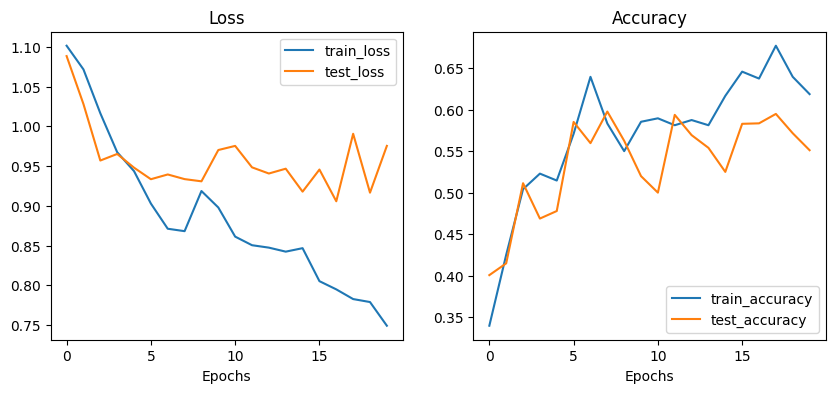

In [29]:
plot_loss_curves(model_2_20e_results)

## Bonus
Add data augmentatino to try reduce overfitting.

In [30]:
# Write a transform for image
data_transform_aug = transforms.Compose([
    # Resize our images to 64x64
    transforms.Resize(size=(64, 64), antialias=None),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Aument images
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()])

# Create train and test datasets
train_dataset_20_percent_aug, test_dataset_20_percent_aug = create_datasets(
    image_path=image_path_20_percent,
    transform=data_transform_aug)

# Get class names as list
class_name_list = train_dataset_20_percent_aug.classes

# Turn train and test datasets into dataloaders
train_dataloader_20_percent_aug, test_dataloader_20_percent = create_dataloaders(
    train_dataset=train_dataset_20_percent_aug,
    test_dataset=test_dataset_20_percent_aug,
    batch_size=BATCH_SIZE)

INFO:root:Creating Datasets.
INFO:root:Turning train and test datasets into dataloaders.


In [31]:
# Set random seeds
torch.manual_seed(1000)
torch.cuda.manual_seed(1000)

# Set num of epochs
NUM_EPOCHS = 50

# Recreate an instance of TinyVGG
model_3_50e = TinyVGG(
    in_channels=3,
    hidden_units=20,
    out_features=3,
    img_shape=(64, 64)).to(device)

# Setup loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_3_50e.parameters(), lr=0.00025)

# Start the timer
start_time = timer()

# Train model
model_3_50e_results = train(
    model=model_3_50e,
    train_dataloader=train_dataloader_20_percent_aug,
    test_dataloader=test_dataloader_20_percent,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=NUM_EPOCHS,
    device=device)

# End timer and print out how long it took
end_time = timer()
print(f"Total training time: {(end_time - start_time):.3f} seconds.")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 | Train_loss: 1.1018, Train_acc: 0.294% | Test_loss: 1.1000, Test_acc: 0.287%
Epoch: 1 | Train_loss: 1.0961, Train_acc: 0.346% | Test_loss: 1.0971, Test_acc: 0.350%
Epoch: 2 | Train_loss: 1.0956, Train_acc: 0.312% | Test_loss: 1.0912, Test_acc: 0.366%
Epoch: 3 | Train_loss: 1.0857, Train_acc: 0.331% | Test_loss: 1.0844, Test_acc: 0.362%
Epoch: 4 | Train_loss: 1.0753, Train_acc: 0.460% | Test_loss: 1.0426, Test_acc: 0.474%
Epoch: 5 | Train_loss: 1.0493, Train_acc: 0.458% | Test_loss: 1.0362, Test_acc: 0.504%
Epoch: 6 | Train_loss: 1.0203, Train_acc: 0.494% | Test_loss: 1.0074, Test_acc: 0.495%
Epoch: 7 | Train_loss: 1.0075, Train_acc: 0.481% | Test_loss: 0.9612, Test_acc: 0.536%
Epoch: 8 | Train_loss: 0.9956, Train_acc: 0.458% | Test_loss: 0.9407, Test_acc: 0.545%
Epoch: 9 | Train_loss: 0.9651, Train_acc: 0.537% | Test_loss: 0.9422, Test_acc: 0.544%
Epoch: 10 | Train_loss: 0.9911, Train_acc: 0.469% | Test_loss: 0.9752, Test_acc: 0.498%
Epoch: 11 | Train_loss: 1.0051, Train_acc:

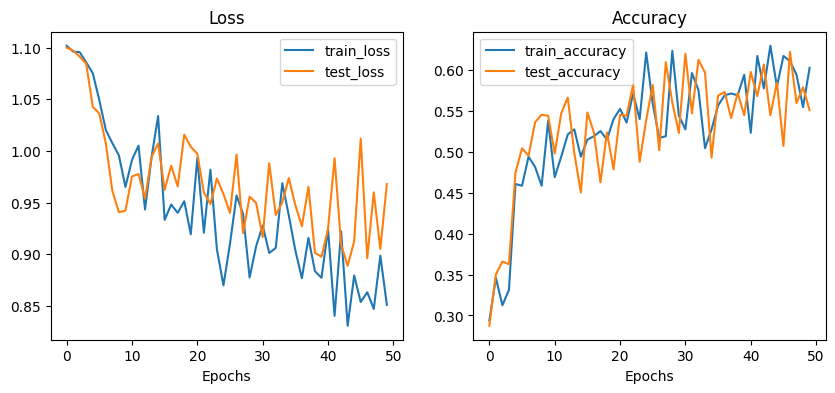

In [32]:
plot_loss_curves(model_3_50e_results)

## Exercise 8
Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) and share your prediction.

* Does the model you trained in exercise 7 get it right?
* If not, what do you whink you could do to improve it?

In [33]:
# Get a custom image
custom_image = "pizza-test.jpg"

with open(custom_image, "wb") as f:
    req = requests.get("https://pixabay.com/get/g3abd3f4dab2956e1c85e026241a33d34118712a7d1ab6e4f7f2583c31acea8516629a12a03808ad27f2dce05e89aa29f886dd308dc0c4ff9c52ad0f1ae8f2fa4_1280.jpg")
    f.write(req.content)

In [34]:
# Load the custom image
img = torchvision.io.read_image(custom_image).type(torch.float32)
img = img / 255.0
img

tensor([[[0.8353, 0.8353, 0.8353,  ..., 0.8588, 0.8588, 0.8588],
         [0.8353, 0.8353, 0.8353,  ..., 0.8588, 0.8588, 0.8588],
         [0.8353, 0.8353, 0.8353,  ..., 0.8588, 0.8588, 0.8588],
         ...,
         [0.7176, 0.7176, 0.7137,  ..., 0.7137, 0.7255, 0.7373],
         [0.7176, 0.7137, 0.7137,  ..., 0.7137, 0.7255, 0.7373],
         [0.7176, 0.7137, 0.7098,  ..., 0.7098, 0.7255, 0.7373]],

        [[0.8510, 0.8510, 0.8510,  ..., 0.8745, 0.8745, 0.8745],
         [0.8510, 0.8510, 0.8510,  ..., 0.8745, 0.8745, 0.8745],
         [0.8510, 0.8510, 0.8510,  ..., 0.8745, 0.8745, 0.8745],
         ...,
         [0.7412, 0.7412, 0.7373,  ..., 0.7333, 0.7333, 0.7451],
         [0.7412, 0.7373, 0.7373,  ..., 0.7333, 0.7333, 0.7451],
         [0.7412, 0.7373, 0.7333,  ..., 0.7294, 0.7333, 0.7451]],

        [[0.8980, 0.8980, 0.8980,  ..., 0.9216, 0.9216, 0.9216],
         [0.8980, 0.8980, 0.8980,  ..., 0.9216, 0.9216, 0.9216],
         [0.8980, 0.8980, 0.8980,  ..., 0.9216, 0.9216, 0.

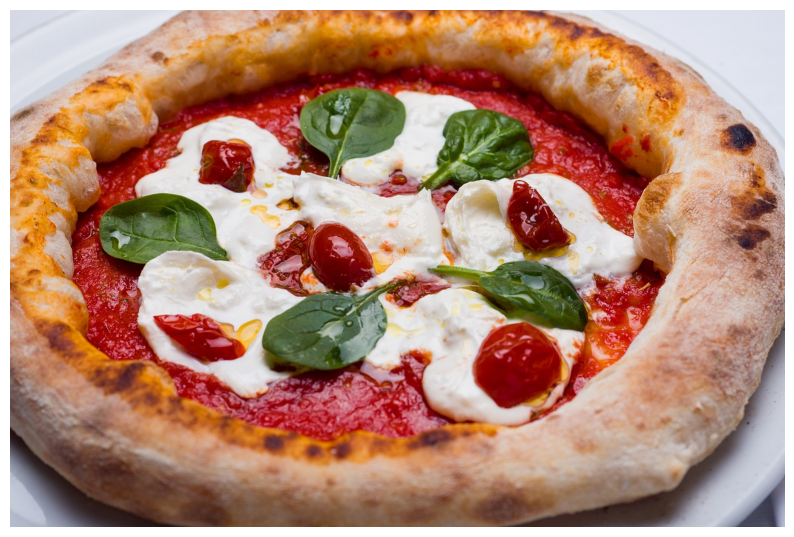

In [35]:
# View the image
plt.figure(figsize=(10,7))
plt.imshow(img.permute(1, 2, 0))
plt.axis(False);

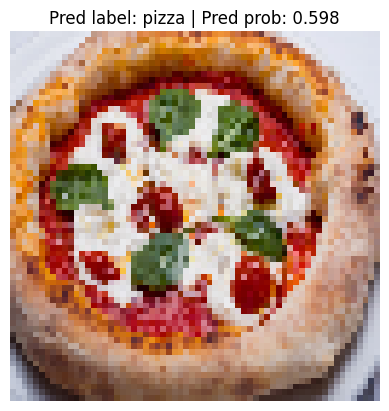

In [36]:
# Make a prediction on the image
model_3_50e.eval()
with torch.inference_mode():
    # Resize image to 64x64
    resize = transforms.Resize(size=(64, 64), antialias=None)
    img = resize(img)

    # Turn image into a bath of a single image and pass to target device
    batch = img.unsqueeze(dim=0).to(device)

    # Predict on image
    y_pred_logit = model_3_50e(batch)
    y_pred_prob = torch.softmax(y_pred_logit, dim=1)
    y_pred_label = torch.argmax(y_pred_prob, dim=1)

# Plo the image and prediction
plt.imshow(img.permute(1, 2, 0))
plt.title(f"Pred label: {class_name_list[y_pred_label.cpu()]} | Pred prob: {y_pred_prob.max().cpu():.3f}")
plt.axis(False);